# Preprocesamiento de Datos Sintéticos de Actividad y Sueño

## Descripción
Este notebook se centra en el preprocesamiento de los datos sintéticos de actividad y sueño para el proyecto de monitorización multimodal de Alzheimer. Las transformaciones aplicadas están guiadas por los hallazgos del análisis exploratorio realizado previamente.

## Objetivos
1. Limpiar y normalizar los datos de actividad y sueño
2. Generar características derivadas con mayor valor predictivo
3. Calcular métricas de variabilidad temporal
4. Preparar los datos para su integración con otras modalidades
5. Exportar los datos preprocesados en un formato adecuado para la siguiente fase


***

## Importación de librerías

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
import os
import warnings

In [3]:
# Configuraciones
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)
%matplotlib inline

print("Iniciando preprocesamiento de datos de actividad y sueño...")

Iniciando preprocesamiento de datos de actividad y sueño...


## Carga de datos

In [4]:
# Definir ruta del archivo
file_path = '../data/raw/synthetic/synthetic_activity_sleep_data.csv'

# Cargar datos
df = pd.read_csv(file_path)

# Mostrar las primeras filas
print("Dimensiones del dataset:", df.shape)
df.head()

Dimensiones del dataset: (54000, 13)


,subject_id,date,diagnosis,age,gender,steps,activity_minutes,sleep_minutes,sleep_disruptions,sedentary_hours,night_activity_minutes,sleep_efficiency,activity_ratio
0,S_001,2023-01-01,Control,53.9,M,7340,137.5,372.8,2.4,12.6,0.0,0.968815,0.153889
1,S_001,2023-01-02,Control,53.9,M,4015,142.9,454.0,1.5,12.3,1.8,0.983749,0.162220
2,S_001,2023-01-03,Control,53.9,M,6925,236.4,375.4,2.1,11.4,0.3,0.972791,0.256845
3,S_001,2023-01-04,Control,53.9,M,7972,231.6,511.0,0.0,13.0,0.0,1.000000,0.228944
4,S_001,2023-01-05,Control,53.9,M,8667,259.7,365.4,3.1,11.0,0.1,0.959307,0.282375


## Análisis inicial y verificación de datos

In [5]:
# Verificar tipos de datos
print("\nTipos de datos:")
print(df.dtypes)

# Verificar valores faltantes
print("\nValores faltantes por columna:")
print(df.isnull().sum())

# Resumen estadístico
print("\nResumen estadístico:")
df.describe()


Tipos de datos:
subject_id                 object
date                       object
diagnosis                  object
age                       float64
gender                     object
steps                       int64
activity_minutes          float64
sleep_minutes             float64
sleep_disruptions         float64
sedentary_hours           float64
night_activity_minutes    float64
sleep_efficiency          float64
activity_ratio            float64
dtype: object

Valores faltantes por columna:
subject_id                0
date                      0
diagnosis                 0
age                       0
gender                    0
steps                     0
activity_minutes          0
sleep_minutes             0
sleep_disruptions         0
sedentary_hours           0
night_activity_minutes    0
sleep_efficiency          0
activity_ratio            0
dtype: int64

Resumen estadístico:


,age,steps,activity_minutes,sleep_minutes,sleep_disruptions,sedentary_hours,night_activity_minutes,sleep_efficiency,activity_ratio
count,54000.000000,54000.000000,54000.000000,54000.000000,54000.000000,54000.000000,54000.000000,54000.000000,54000.000000
mean,69.327539,5250.872167,163.238030,330.899506,4.481694,13.249431,3.238835,0.923242,0.169973
std,9.023807,2460.741287,80.253944,94.182210,3.037818,1.921309,5.889153,0.075291,0.081521
min,37.000000,0.000000,0.000000,47.500000,0.000000,8.700000,0.000000,0.359848,0.000000
25%,63.800000,3395.000000,101.400000,269.500000,2.200000,11.900000,0.300000,0.902764,0.108046
50%,69.500000,5366.000000,167.900000,350.400000,3.700000,12.800000,1.000000,0.948769,0.175517
75%,75.300000,7076.000000,225.200000,401.600000,6.200000,14.200000,3.500000,0.972513,0.233601
max,105.100000,16877.000000,508.700000,665.300000,21.400000,20.800000,108.600000,1.000000,0.471366


## Preprocesamiento básico

In [6]:
### Conversión de tipos de datos

# Convertir 'date' a datetime
df['date'] = pd.to_datetime(df['date'])

# Extraer componentes temporales útiles
df['day_of_week'] = df['date'].dt.dayofweek  # 0-6, donde 0 es lunes
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

print("Componentes temporales extraídos.")

### Manejo de valores faltantes

# Verificar outliers extremos (posibles errores de registro)
print("\nVerificando outliers extremos en variables numéricas...")

for col in ['steps', 'activity_minutes', 'sleep_minutes', 'sleep_disruptions', 
           'sedentary_hours', 'night_activity_minutes', 'sleep_efficiency']:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 3 * iqr
    upper_bound = q3 + 3 * iqr
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
    print(f"{col}: {outliers} outliers extremos detectados")

# Imputación de valores faltantes
print("\nImputando valores faltantes...")

# Para variables numéricas relacionadas con actividad y sueño
numeric_cols = ['steps', 'activity_minutes', 'sleep_minutes', 'sleep_disruptions', 
               'sedentary_hours', 'night_activity_minutes', 'sleep_efficiency']

# Usar una estrategia de imputación basada en mediana por grupo diagnóstico
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        # Imputación por grupo diagnóstico
        df_temp = df.copy()
        for diagnosis in df['diagnosis'].unique():
            mask = (df['diagnosis'] == diagnosis) & (df[col].isnull())
            df.loc[mask, col] = df[df['diagnosis'] == diagnosis][col].median()
        
        # Si quedan faltantes, usar la mediana general
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].median(), inplace=True)

print("Imputación completada.")

Componentes temporales extraídos.

Verificando outliers extremos en variables numéricas...
steps: 0 outliers extremos detectados
activity_minutes: 0 outliers extremos detectados
sleep_minutes: 0 outliers extremos detectados
sleep_disruptions: 18 outliers extremos detectados
sedentary_hours: 0 outliers extremos detectados
night_activity_minutes: 2910 outliers extremos detectados
sleep_efficiency: 1265 outliers extremos detectados

Imputando valores faltantes...
Imputación completada.


## Generación de características derivadas

In [7]:
print("\nGenerando características derivadas...")

# 1. Ratios y métricas compuestas (identificadas como importantes en el EDA)
df['night_to_sleep_ratio'] = df['night_activity_minutes'] / df['sleep_efficiency']
df['activity_to_sedentary_ratio'] = df['activity_minutes'] / (df['sedentary_hours'] * 60)
df['step_efficiency'] = df['steps'] / df['activity_minutes']

# 2. Variabilidad temporal (entre semana vs. fin de semana)
# Primero creamos DataFrames separados para días laborables y fines de semana
df_weekday = df[df['is_weekend'] == 0].copy()
df_weekend = df[df['is_weekend'] == 1].copy()

# Calcular promedios por sujeto para días laborables y fines de semana
weekday_avg = df_weekday.groupby('subject_id')[numeric_cols].mean().reset_index()
weekend_avg = df_weekend.groupby('subject_id')[numeric_cols].mean().reset_index()

# Renombrar columnas para distinguir entre semana y fin de semana
weekday_cols = {col: f"{col}_weekday" for col in numeric_cols}
weekend_cols = {col: f"{col}_weekend" for col in numeric_cols}

weekday_avg = weekday_avg.rename(columns=weekday_cols)
weekend_avg = weekend_avg.rename(columns=weekend_cols)

# Combinar los promedios
temporal_vars = pd.merge(weekday_avg, weekend_avg, on='subject_id', how='outer')

# Calcular las variaciones entre semana y fin de semana
for col in numeric_cols:
    temp_col = f"{col}_variation"
    temporal_vars[temp_col] = (temporal_vars[f"{col}_weekend"] - 
                             temporal_vars[f"{col}_weekday"]) / temporal_vars[f"{col}_weekday"] * 100

# 3. Agregar las variaciones temporales al DataFrame original
df = pd.merge(df, 
             temporal_vars[['subject_id'] + [f"{col}_variation" for col in numeric_cols]],
             on='subject_id', 
             how='left')

print("Características derivadas generadas.")


Generando características derivadas...
Características derivadas generadas.


## Normalización y escalado

In [8]:
print("\nNormalizando variables...")

# Definir columnas para escalar (numéricas continuas)
cols_to_scale = numeric_cols + ['night_to_sleep_ratio', 'activity_to_sedentary_ratio', 'step_efficiency']

# Paso 1: Manejar infinitos
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(subset=cols_to_scale, inplace=True)

# Paso 2: Aplicar RobustScaler
scaler = RobustScaler()
scaled_cols = [f"{col}_scaled" for col in cols_to_scale]  # Nombres nuevos
df[scaled_cols] = scaler.fit_transform(df[cols_to_scale])

# Paso 3: Codificar género (sin cambios)
df['gender_code'] = df['gender'].map({'F': 0, 'M': 1})

print("Normalización completada.")


Normalizando variables...
Normalización completada.


## Detección de anomalías en patrones de sueño

In [9]:
print("\nDetectando patrones anómalos de sueño...")

# Definir umbrales basados en los hallazgos del EDA
sleep_disruption_threshold = df['sleep_disruptions'].mean() + 2 * df['sleep_disruptions'].std()
sleep_efficiency_threshold = df['sleep_efficiency'].mean() - 2 * df['sleep_efficiency'].std()

# Crear flags de anomalías
df['anomalous_sleep_disruptions'] = df['sleep_disruptions'] > sleep_disruption_threshold
df['anomalous_sleep_efficiency'] = df['sleep_efficiency'] < sleep_efficiency_threshold
df['any_sleep_anomaly'] = df['anomalous_sleep_disruptions'] | df['anomalous_sleep_efficiency']

# Contar anomalías por sujeto
sleep_anomalies = df.groupby('subject_id')['any_sleep_anomaly'].sum().reset_index()
sleep_anomalies.rename(columns={'any_sleep_anomaly': 'total_sleep_anomalies'}, inplace=True)

# Agregar conteo al DataFrame principal
df = pd.merge(df, sleep_anomalies, on='subject_id', how='left')

print("Detección de anomalías completada.")


Detectando patrones anómalos de sueño...
Detección de anomalías completada.


## Agregaciones temporales por semana y mes

In [10]:
print("\nCreando agregaciones temporales...")

# Añadir semana y mes como unidades de tiempo
df['week'] = df['date'].dt.isocalendar().week
df['month'] = df['date'].dt.month

# Variables a agregar
agg_vars = ['steps', 'activity_minutes', 'sleep_minutes', 'sleep_disruptions', 
           'night_activity_minutes', 'sleep_efficiency']

# Agregaciones semanales
weekly_aggs = df.groupby(['subject_id', 'week'])[agg_vars].agg(['mean', 'std', 'min', 'max']).reset_index()
weekly_aggs.columns = ['subject_id', 'week'] + [f"{var}_{agg}_weekly" for var in agg_vars for agg in ['mean', 'std', 'min', 'max']]

# Agregaciones mensuales
monthly_aggs = df.groupby(['subject_id', 'month'])[agg_vars].agg(['mean', 'std', 'min', 'max']).reset_index()
monthly_aggs.columns = ['subject_id', 'month'] + [f"{var}_{agg}_monthly" for var in agg_vars for agg in ['mean', 'std', 'min', 'max']]

print("Agregaciones temporales creadas.")


Creando agregaciones temporales...
Agregaciones temporales creadas.


## Preparacón de dataset final para análisis

In [11]:
print("\nPreparando dataset final...")

# 1. Dataset a nivel de registro diario (conservando todas las características)
daily_df = df.copy()

# 2. Dataset a nivel de sujeto con estadísticas agregadas
subject_df = df.groupby(['subject_id', 'diagnosis', 'age', 'gender']).agg({
    'steps': ['mean', 'std', 'min', 'max'],
    'activity_minutes': ['mean', 'std', 'min', 'max'],
    'sleep_minutes': ['mean', 'std', 'min', 'max'],
    'sleep_disruptions': ['mean', 'std', 'min', 'max'],
    'sedentary_hours': ['mean', 'std', 'min', 'max'],
    'night_activity_minutes': ['mean', 'std', 'min', 'max'],
    'sleep_efficiency': ['mean', 'std', 'min', 'max'],
    'night_to_sleep_ratio': ['mean', 'std'],
    'activity_to_sedentary_ratio': ['mean', 'std'],
    'step_efficiency': ['mean', 'std'],
    'total_sleep_anomalies': 'max'
}).reset_index()

# Aplanar nombres de columnas
subject_df.columns = ['_'.join(col).strip('_') for col in subject_df.columns.values]

# Abraham Tartalos
# 3. Unir las características de variabilidad temporal
variation_cols = [f"{col}_variation" for col in numeric_cols]
temp_vars_subset = temporal_vars[['subject_id'] + variation_cols].drop_duplicates()
subject_df = pd.merge(subject_df, temp_vars_subset, on='subject_id', how='left')

# 4. Asegurarse de que no hay valores faltantes
# Se imputan los valores faltantes por la media
print("Valores faltantes antes de imputación:", subject_df.isnull().sum().sum())
subject_df = subject_df.fillna(subject_df.mean(numeric_only=True))

print("="*80)
print("Dataset final preparado.")
print("Valores faltantes después de imputación:", subject_df.isnull().sum().sum())


Preparando dataset final...
Valores faltantes antes de imputación: 160
Dataset final preparado.
Valores faltantes después de imputación: 0


## Visualización de verificación

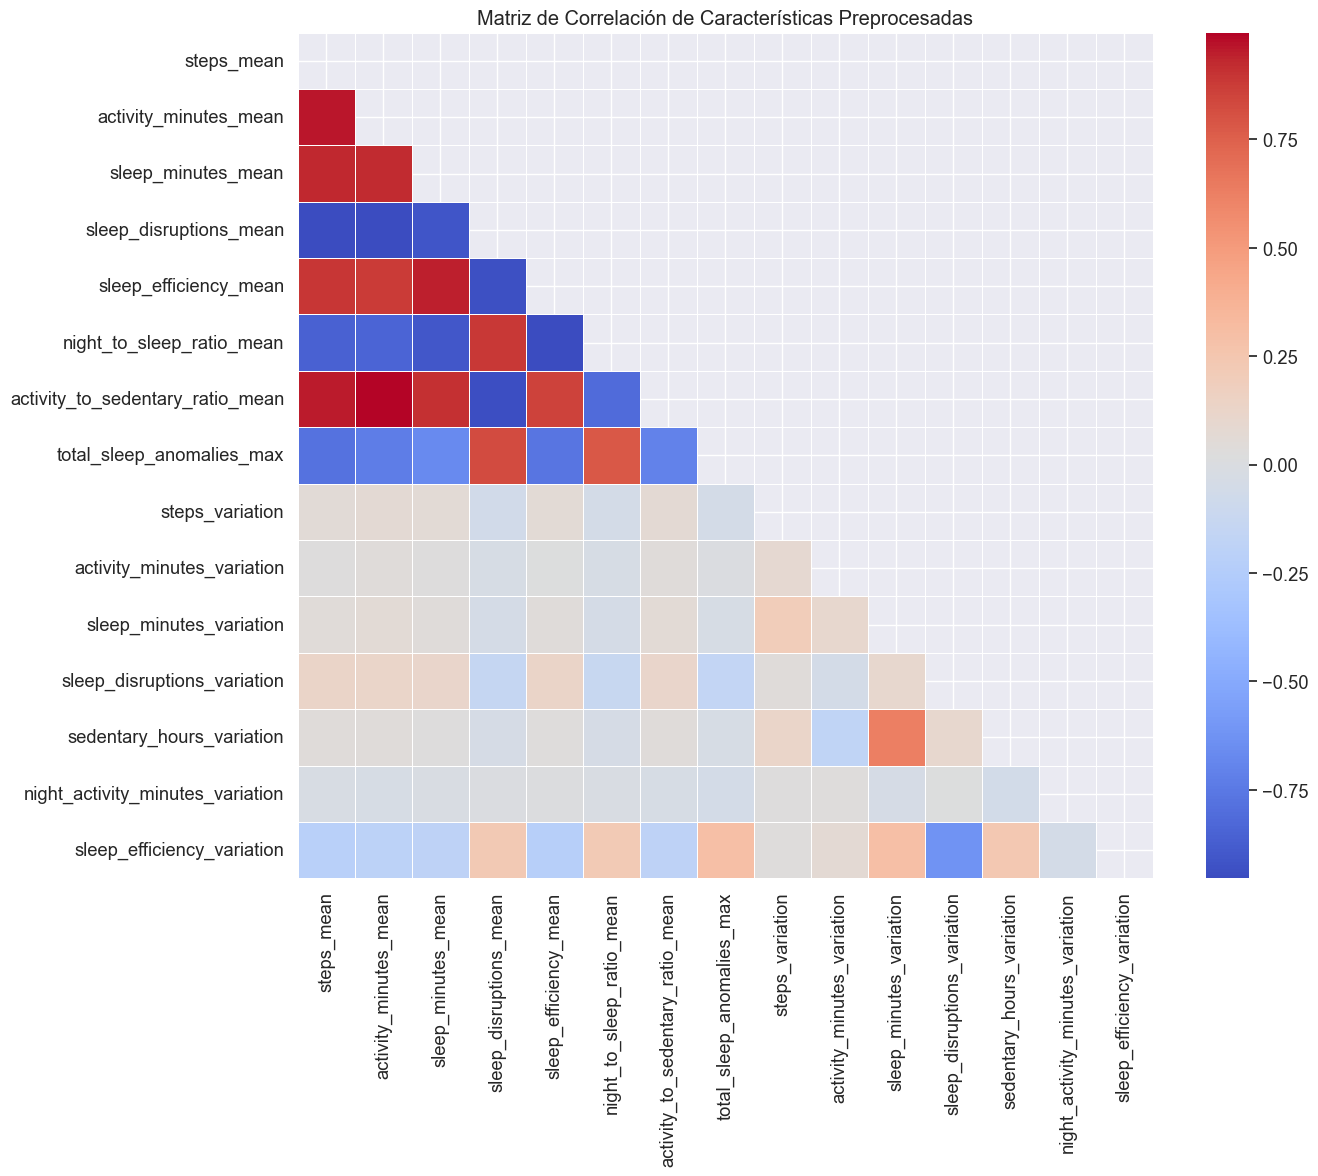

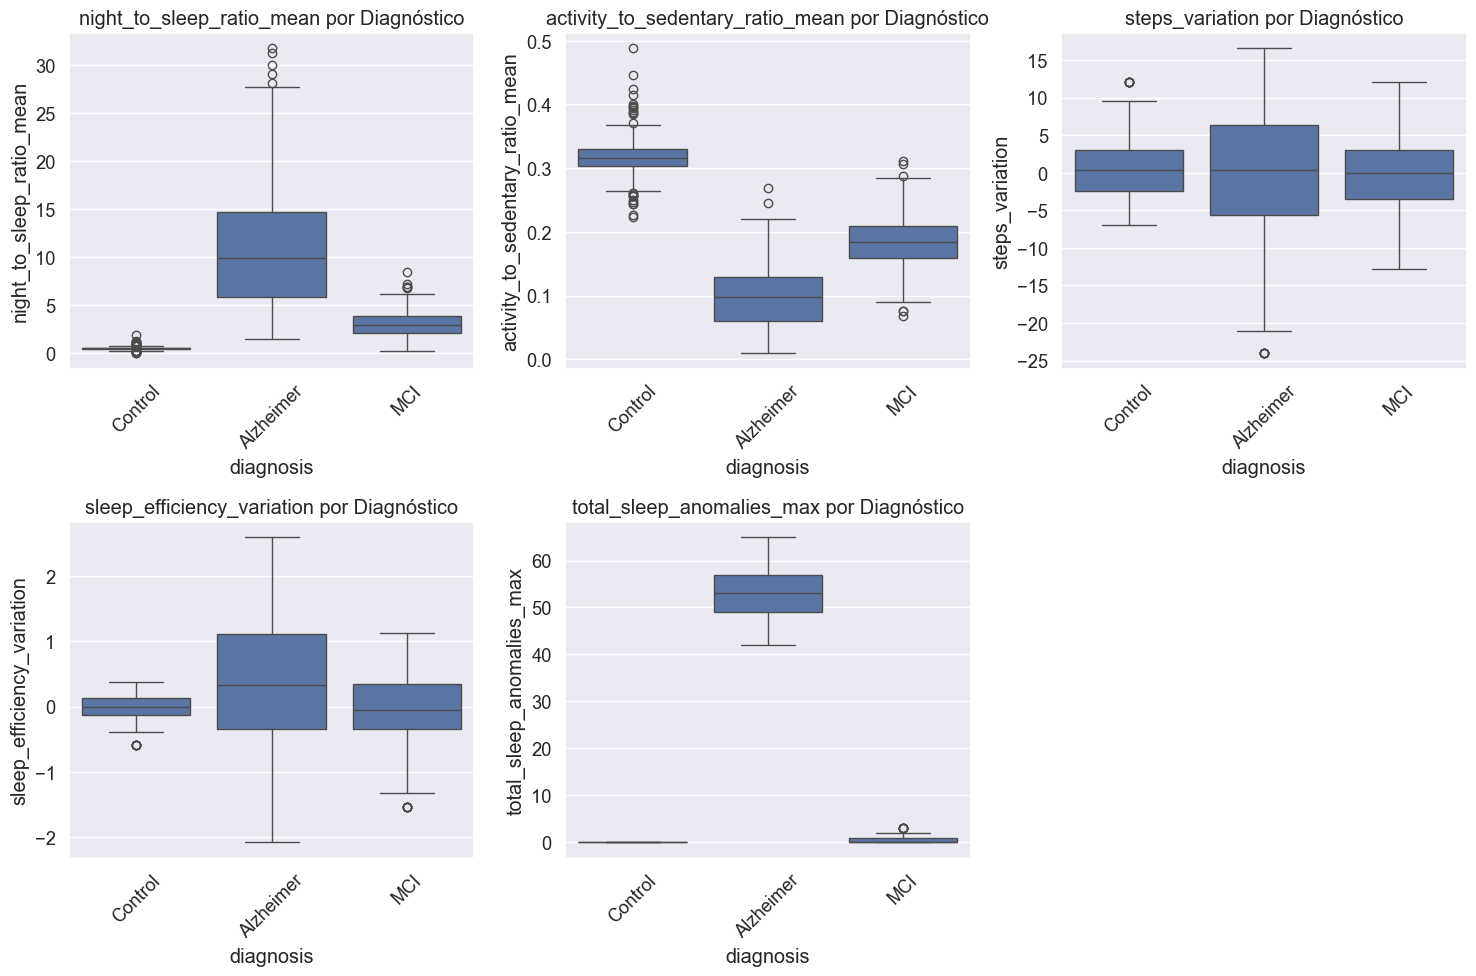

In [12]:
# Matriz de correlación de las nuevas características a nivel de sujeto
plt.figure(figsize=(14, 12))
selected_cols = [
    'steps_mean', 
    'activity_minutes_mean', 
    'sleep_minutes_mean',
    'sleep_disruptions_mean', 
    'sleep_efficiency_mean', 
    'night_to_sleep_ratio_mean', 
    'activity_to_sedentary_ratio_mean',
    'total_sleep_anomalies_max'  # Nombre correcto tras agregación
] + [col for col in subject_df.columns if 'variation' in col]

corr = subject_df[selected_cols].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=False, cmap='coolwarm', linewidths=.5)
plt.title('Matriz de Correlación de Características Preprocesadas')
plt.tight_layout()
plt.show()

# Verificar diferencias entre grupos diagnósticos en características derivadas
plt.figure(figsize=(15, 10))
for i, col in enumerate([
    'night_to_sleep_ratio_mean', 
    'activity_to_sedentary_ratio_mean', 
    'steps_variation', 
    'sleep_efficiency_variation', 
    'total_sleep_anomalies_max'  # Nombre corregido
]):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='diagnosis', y=col, data=subject_df)
    plt.title(f'{col} por Diagnóstico')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## Exportación de datos

In [13]:
subject_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1777 entries, 0 to 1776
Data columns (total 46 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   subject_id                        1777 non-null   object 
 1   diagnosis                         1777 non-null   object 
 2   age                               1777 non-null   float64
 3   gender                            1777 non-null   object 
 4   steps_mean                        1777 non-null   float64
 5   steps_std                         1777 non-null   float64
 6   steps_min                         1777 non-null   int64  
 7   steps_max                         1777 non-null   int64  
 8   activity_minutes_mean             1777 non-null   float64
 9   activity_minutes_std              1777 non-null   float64
 10  activity_minutes_min              1777 non-null   float64
 11  activity_minutes_max              1777 non-null   float64
 12  sleep_

In [27]:
# Crear directorio de salida si no existe
output_dir = '../data/processed/'
os.makedirs(output_dir, exist_ok=True)

# Exportar conjunto de datos diarios
daily_df.to_csv(output_dir + 'processed_activity_sleep_daily.csv', index=False)
print(f"- Datos diarios guardados en {output_dir}processed_activity_sleep_daily.csv")

# Exportar conjunto de datos a nivel de sujeto
subject_df.to_csv(output_dir + 'processed_activity_sleep_subject.csv', index=False)
print(f"- Datos a nivel de sujeto guardados en {output_dir}processed_activity_sleep_subject.csv")


Datos diarios guardados en ../data/processed/processed_activity_sleep_daily.csv
Datos a nivel de sujeto guardados en ../data/processed/processed_activity_sleep_subject.csv


## Resumen de preprocesamiento

In [31]:
print("\n=== Resumen del Preprocesamiento ===")
print(f"- Registros diarios procesados: {daily_df.shape[0]}")
print(f"- Sujetos únicos: {subject_df.shape[0]}")
print(f"- Características originales: {len(df.columns)}")
print(f"- Características derivadas en dataset diario: {len(daily_df.columns)}")
print(f"- Características agregadas en dataset de sujetos: {len(subject_df.columns)}")
print("\nCaracterísticas principales generadas:")
print("- Ratios de actividad y sueño")
print("- Variaciones entre semana/fin de semana")
print("- Detección de anomalías de sueño")
print("- Agregaciones temporales (diarias, semanales, mensuales)")
print("- Variables normalizadas para modelado")

# Verificar completitud del preprocesamiento
missing_subject = subject_df.isnull().sum().sum()
print(f"\nValores faltantes en dataset de sujetos: {missing_subject}")
print("⚡  Preprocesamiento completado exitosamente.  ⚡")


=== Resumen del Preprocesamiento ===
- Registros diarios procesados: 53260
- Sujetos únicos: 1777
- Características originales: 43
- Características derivadas en dataset diario: 43
- Características agregadas en dataset de sujetos: 46

Características principales generadas:
- Ratios de actividad y sueño
- Variaciones entre semana/fin de semana
- Detección de anomalías de sueño
- Agregaciones temporales (diarias, semanales, mensuales)
- Variables normalizadas para modelado

Valores faltantes en dataset de sujetos: 0
⚡  Preprocesamiento completado exitosamente.  ⚡


***

###### __Abraham Tartalos__